In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-09-09 14:14:58--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-09-09 14:14:58 (6.18 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

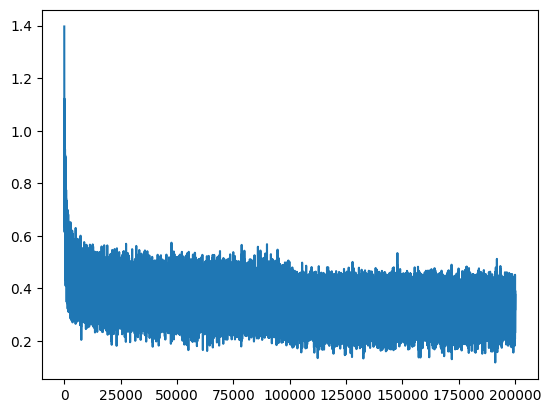

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1330, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1782, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1726, grad_fn=<NllLossBackward0>)

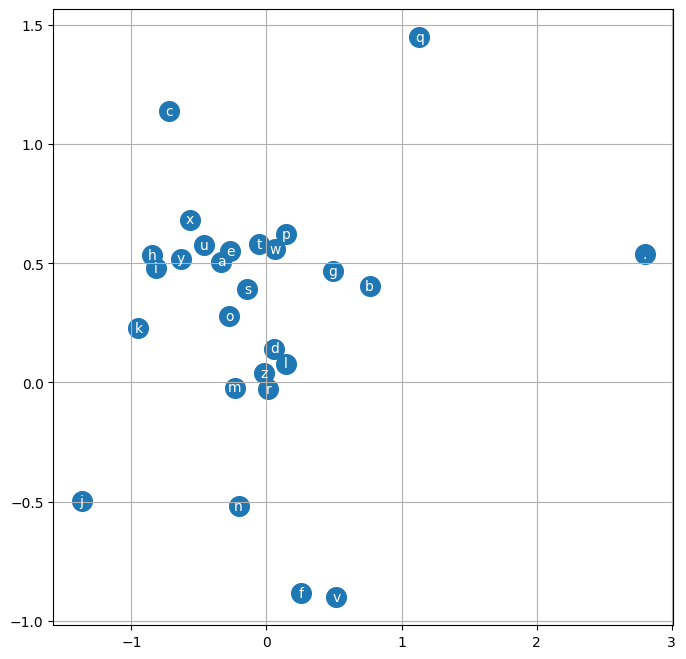

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayanniel.
med.
ryla.
rethruthadraeg.
aderedieli.
jemi.
jenrekeiseananar.
elyn.
malya.
cayshdynz.
shiriel.
kendreellephetton.
kuba.
ged.
ryyah.
faeks.
kayshia.
kyla.
hal.


#Ex1: Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [ ]:
# We first increase the number of neurons in the hidden layer, 200 -> 250.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 250), generator=g)
b1 = torch.randn(250, generator=g)
W2 = torch.randn((250, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # new number of parameters

14797

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1226, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1698, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1779, grad_fn=<NllLossBackward0>)

In [ ]:
# We're not doing better on the test set, so we're starting to overfit the training set.
# So, let's come back to 200 neurons in the hidden layer and increase instead the dimensionality of our embedding from 10 to 12.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # new number of parameter

13151

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1070, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1584, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1596, grad_fn=<NllLossBackward0>)

In [ ]:
# We're doing better!
# Let's visualize dimensions 0 and 1 of the embedding matrix C for all characters

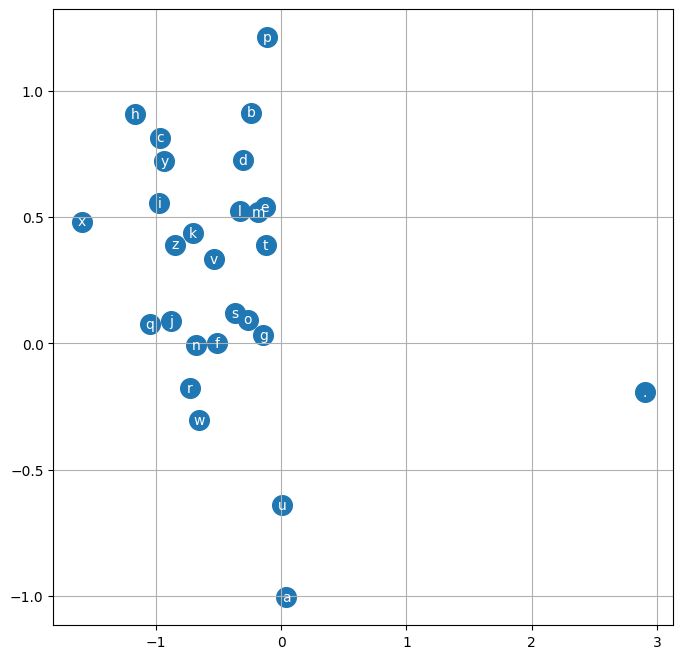

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# Can we improve the loss further? Let's try to enlarge the context length from 3 to 5 characters.

In [ ]:
# build the dataset
block_size = 5 # context length

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 5]) torch.Size([182580])
torch.Size([22767, 5]) torch.Size([22767])
torch.Size([22799, 5]) torch.Size([22799])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((60, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # new number of parameter

17951

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 5, 12)
  h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1605, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1871, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1922, grad_fn=<NllLossBackward0>)

In [ ]:
# The loss has increased! Maybe we don't have enough neurons in the hidden layer anymore, let's try to ramp it up.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((60, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # new number of parameter

26751

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 5, 12)
  h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1884, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2153, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2190, grad_fn=<NllLossBackward0>)

In [ ]:
# Ok, let's come back to our previous setting, i.e. 3 tokens of context and 200 neurons in the hidden layer, and we will increase the size of the minibatches instead.

In [ ]:
# build the dataset
block_size = 3 # context length

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # new number of parameter

13151

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,)) # we increase the size of a minibatch from 32 to 100

  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 2)
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0977, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1591, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1546, grad_fn=<NllLossBackward0>)

In [ ]:
# We achieved our best loss to date.
# Let's increase the number of steps.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(300000): # we increase the number of steps

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 2)
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0979, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1599, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1496, grad_fn=<NllLossBackward0>)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nihayla.
rethan.
endraeg.
aderedielin.
shy.
jena.
keisean.
aarvelynn.
honelin.
shub.
rgahimies.
kinde.
jelionnie.
cayus.
kaven.
kylene.
els.


In [ ]:
# Slighly better, but not much.
# Let's try to tweak the learning rate.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True


In [ ]:
for i in range(300000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 12)
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.05 if i < 100000 else 0.01 # we divide the learning rate by 2
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1409, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1885, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1810, grad_fn=<NllLossBackward0>)

In [ ]:
# Let's increase the learning rate instead.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(300000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))
  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 12)
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.5 if i < 200000 else 0.1 # we increase the learning rate
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0649, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1750, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1786, grad_fn=<NllLossBackward0>)

In [ ]:
# Let's try to take this one step further by fine-tuning the leaning rate.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(300000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 12)
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # we fine-tune the learning rate
  if i < 100000:
    lr = 0.5
  elif i < 250000:
    lr = 0.1
  else:
    lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0154, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1210, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1177, grad_fn=<NllLossBackward0>)

In [ ]:
# We make a last try.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(300000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 12)
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # we fine-tune the learning rate
  if i < 100000:
    lr = 1
  elif i < 200000:
    lr = 0.5
  elif i < 250000:
    lr = 0.1
  else:
    lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9927, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0964, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.0988, grad_fn=<NllLossBackward0>)

Our best loss on the test set: 2.0988.

# Ex2: Intialization of the network.

## (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?

In [ ]:
# Seed for reproducibility
g = torch.Generator().manual_seed(2147483647)

In [ ]:
# Initialize weights and biases
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)

In [ ]:
# Initialize W2 and b2 to ensure uniform probabilities
W2 = torch.zeros(200, 27)  # All zeros to make logits equal
b2 = torch.zeros(27)  # All zeros to make logits equal

In [ ]:
# List of parameters
parameters = [C, W1, b1, W2, b2]

In [ ]:
# Set requires_grad=True for each parameter
for p in parameters:
    p.requires_grad = True

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.2958, grad_fn=<NllLossBackward0>)

In [1]:
# We get a loss of -ln(1/27) as expected.

## (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

Yes, for this it suffices to initialize the weights W2 and biaises b2 with small random values.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.01 # we initialize W2 and b2 with small random values
b2 = torch.randn(27, generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.2958, grad_fn=<NllLossBackward0>)

##  Ex3: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [ ]:
# Following Bengio et al 2003, we implement the following changes:
# 1) We extend the context to 4 words
# 2) We add a regularization term to the weights of the neural network and to the C matrix (but not to the biases)

In [ ]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182661, 4]) torch.Size([182661])
torch.Size([22763, 4]) torch.Size([22763])
torch.Size([22722, 4]) torch.Size([22722])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((48, 200), generator=g) # four characters of context instead of three
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for i in range(300000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]] # (100, 4, 12)
  h = torch.tanh(emb.view(-1, 48) @ W1 + b1)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) + 0.01 * (W1.pow(2).mean() + W2.pow(2).mean() + C.pow(2).mean())  # we add a regularization term

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  if i < 100000:
    lr = 1
  elif i < 200000:
    lr = 0.5
  elif i < 250000:
    lr = 0.1
  else:
    lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 48) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9036, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 48) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0340, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 48) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.0553, grad_fn=<NllLossBackward0>)

We were able to decrease the loss further: 2.0553.

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayanna.
elme.
hayla.
remmani.
jerne.
caderediel.
izell.
jenreden.
estana.
selyn.
malkia.
noshaber.
shivie.
trinio.
jenson.
teron.
ubuk.
cdir.
yarul.
